In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from tqdm import tqdm

In [2]:
from catboost.utils import get_gpu_device_count
print("Available GPU count:", get_gpu_device_count())


Available GPU count: 1


In [3]:
df = pd.read_csv('data/ts2024.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], format='ISO8601')
hourly_index = pd.date_range(start=df['DateTime'].min(), end=df['DateTime'].max(), freq='H')
df['DateTime'] = hourly_index
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['DayOfMonth'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year


In [4]:

df = pd.read_csv('data/ts2024.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], format='ISO8601')
hourly_index = pd.date_range(start=df['DateTime'].min(), end=df['DateTime'].max(), freq='H')
df['DateTime'] = hourly_index
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['DayOfMonth'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year

df = df.set_index(hourly_index).rename_axis('date')



train = df[df['X'].notna()]
test = df[df['X'].isna()]






In [5]:
len(test)

744

In [6]:
def create_lagged_features(data, lag):
    df = pd.DataFrame({'Date': data.index, 'Value': data.X})
    
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Value'].shift(i)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    feature_cols = [f'lag_{i}' for i in range(lag, 0, -1)]
    X = df[feature_cols].values    
    y = df['Value'].values
    
    return X, y

lag = 1000
X, y = create_lagged_features(train, lag)

X_train, y_train = X[:-1000], y[:-1000]
X_valid, y_valid = X[-1000:], y[-1000:]


model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          depth=5,
                          task_type="GPU",
                          l2_leaf_reg=10,
                          devices='0',
                          verbose=100)
model.fit(X_train, y_train)



0:	learn: 0.0450755	total: 30ms	remaining: 30s
100:	learn: 0.0157158	total: 2.18s	remaining: 19.4s
200:	learn: 0.0137973	total: 4.3s	remaining: 17.1s
300:	learn: 0.0124202	total: 6.43s	remaining: 14.9s
400:	learn: 0.0113903	total: 8.54s	remaining: 12.7s
500:	learn: 0.0105583	total: 10.7s	remaining: 10.6s
600:	learn: 0.0097200	total: 12.8s	remaining: 8.52s
700:	learn: 0.0091297	total: 15s	remaining: 6.38s
800:	learn: 0.0086856	total: 17.1s	remaining: 4.25s
900:	learn: 0.0083021	total: 19.2s	remaining: 2.11s
999:	learn: 0.0080080	total: 21.3s	remaining: 0us


### predictions on valid set

In [12]:
def predict_horizon(model, current_input, horizon):

    predictions = []


    for _ in range(horizon):
        # Make prediction for the next step
        pred = model.predict(current_input.reshape(1, -1))  # Reshape for model input (1 sample, lag features)
        predictions.append(pred[0])

        # Update input for the next prediction (move the predictions to the left)
        current_input = np.concatenate((current_input[1:], [pred[0]]))

    return predictions

In [8]:
def create_sequences(time_series, n_lags, z_lags):
    X, y = [], []
    for i in range(len(time_series) - n_lags - z_lags + 1):

        X.append(time_series[i:i + n_lags])
        y.append(time_series[i + n_lags:i + n_lags + z_lags])
    return np.array(X), np.array(y)


X_seq, y_seq = create_sequences(train['X'].tolist(), 1000, 744)


In [9]:
X_seq_train = X_seq[:len(X) - len(X_valid)] 
y_seq_train = y_seq[:len(X) - len(X_valid)]
X_seq_valid = X_seq[len(X) - len(X_valid):]
y_seq_valid = y_seq[len(X) - len(X_valid):]


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import numpy as np


# Calculating RMSE
def mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) ** 2)


# Calculating SMAPE (Symmetric Mean Absolute Percentage Error)
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [13]:
valid_preds = []
y_valid = []
for i in tqdm(range(0, len(X_seq_valid), 10)):
    pred = predict_horizon(model, X_seq_valid[i], len(y_seq_valid[i]))
    valid_preds.append(pred)
    y_valid.append(y_seq_valid[i])
valid_preds = np.array(valid_preds)
y_valid = np.array(y_valid)




100%|██████████| 26/26 [00:55<00:00,  2.12s/it]


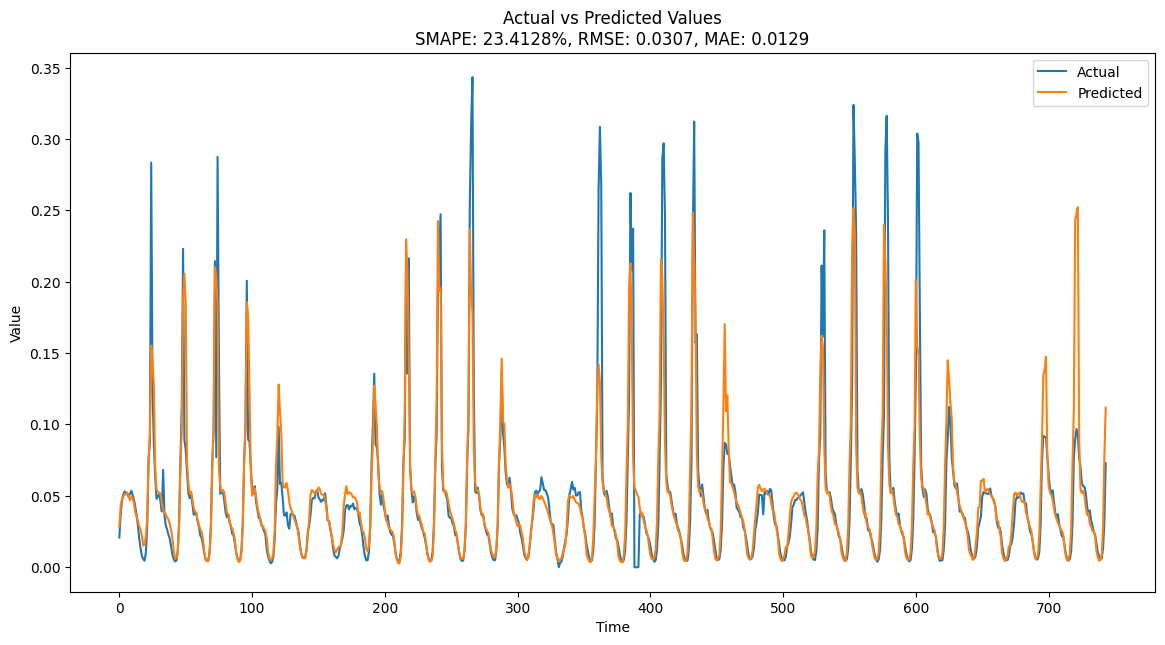

In [15]:

index_chosen = 7

rmse = np.sqrt(mean_squared_error(valid_preds[index_chosen], y_valid[index_chosen]))
mae = mean_absolute_error(valid_preds[index_chosen], y_valid[index_chosen])
smape = symmetric_mean_absolute_percentage_error(valid_preds[index_chosen], y_valid[index_chosen])

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_valid[index_chosen], label='Actual')
plt.plot(valid_preds[index_chosen], label='Predicted')
plt.legend()
plt.title(f'Actual vs Predicted Values\nSMAPE: {smape:.4f}%, RMSE: {rmse:.4f}, MAE: {mae:.4f}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()



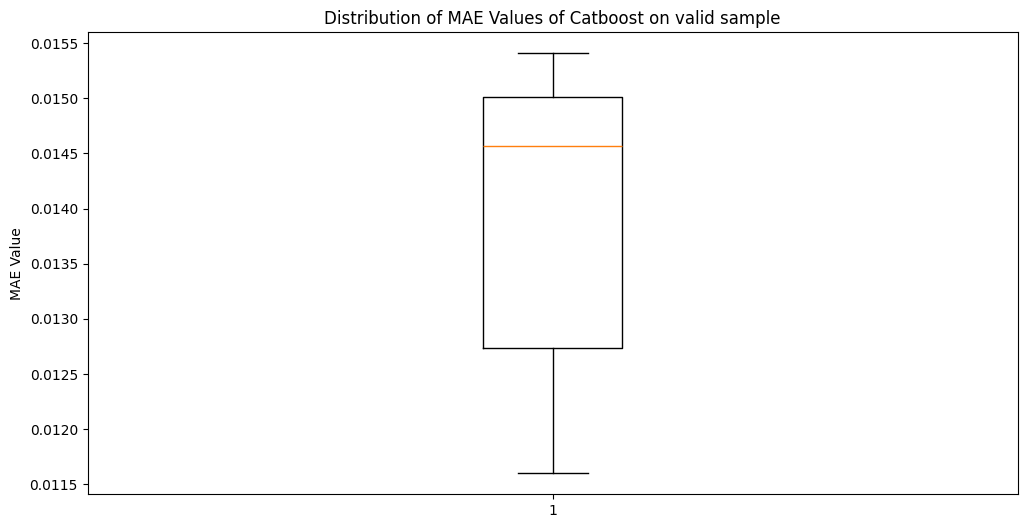

In [18]:
mae_values = [mean_absolute_error(y_valid[i], valid_preds[i]) for i in range(len(y_valid))]

plt.figure(figsize=(12, 6))
plt.boxplot(mae_values)
plt.title("Distribution of MAE Values of Catboost on valid sample")
plt.ylabel("MAE Value")
plt.show()

# Predict on the final set

In [16]:
#retrain model

model_full = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          depth=5,
                          task_type="GPU",
                          l2_leaf_reg=10,
                          devices='0',
                          verbose=100)
model_full.fit(X, y)


0:	learn: 0.0452233	total: 25.5ms	remaining: 25.5s
100:	learn: 0.0160602	total: 2.17s	remaining: 19.3s
200:	learn: 0.0140361	total: 4.3s	remaining: 17.1s
300:	learn: 0.0127423	total: 6.44s	remaining: 15s
400:	learn: 0.0117858	total: 8.51s	remaining: 12.7s
500:	learn: 0.0108848	total: 10.6s	remaining: 10.6s
600:	learn: 0.0102334	total: 12.8s	remaining: 8.49s
700:	learn: 0.0096206	total: 15s	remaining: 6.38s
800:	learn: 0.0091624	total: 17.1s	remaining: 4.25s
900:	learn: 0.0087144	total: 19.3s	remaining: 2.12s
999:	learn: 0.0083918	total: 21.4s	remaining: 0us


In [17]:
last_values = np.array(train['X'].tolist()[-1000:])

In [18]:
prediction_full = predict_horizon(model_full, last_values, len(test))

In [24]:
deep_learning_prediction = pd.DataFrame({'Date': test.index, 'ML': prediction_full})
deep_learning_prediction.to_csv('outputs/deep_learning_prediction.csv', index=False)

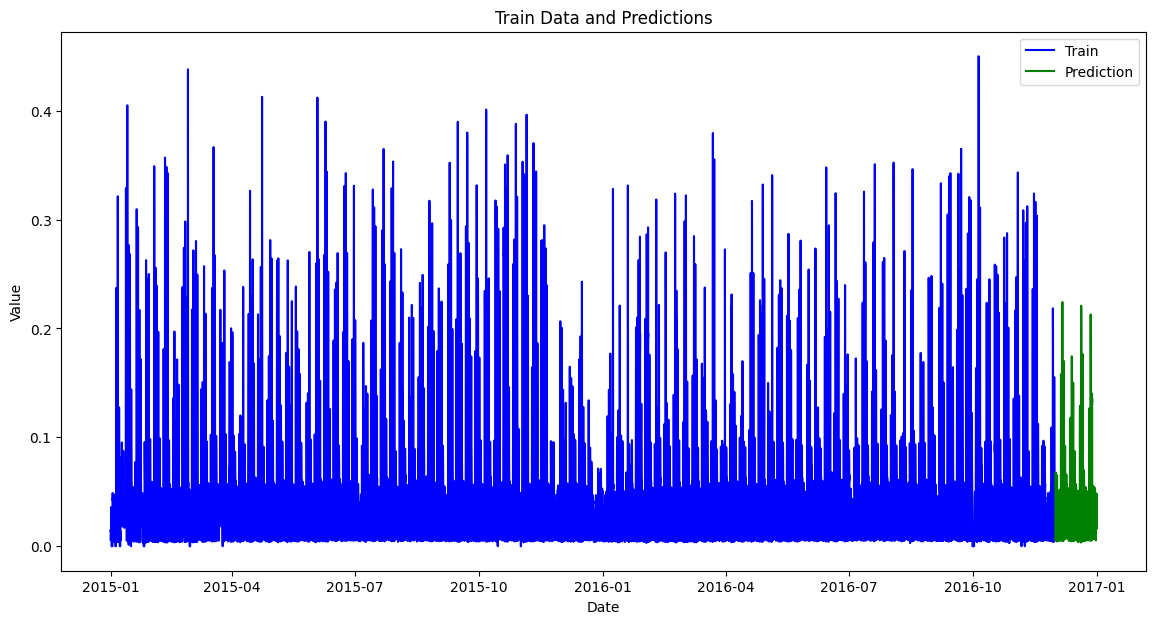

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['X'], label='Train', color='blue')
plt.plot(deep_learning_prediction['Date'], deep_learning_prediction['ML'], label='Prediction', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train Data and Predictions')
plt.legend()
plt.show()


In [8]:
#predictions
n_forecast = len(test)  
predictions = [] 


last_value = df.iloc[-1]['Value']


last_features = X[-1]

forecast_input = np.concatenate(([last_value], last_features[:-1]))
current_input = forecast_input.copy()
for i in range(n_forecast):
    # Приводим current_input к форме (1, lag)
    pred = model.predict(current_input.reshape(1, -1))
    predictions.append(pred[0])

    current_input = np.concatenate(([pred[0]], current_input[:-1]))


last_date = df.iloc[-1]['Date']
future_dates = test.index

forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': predictions})

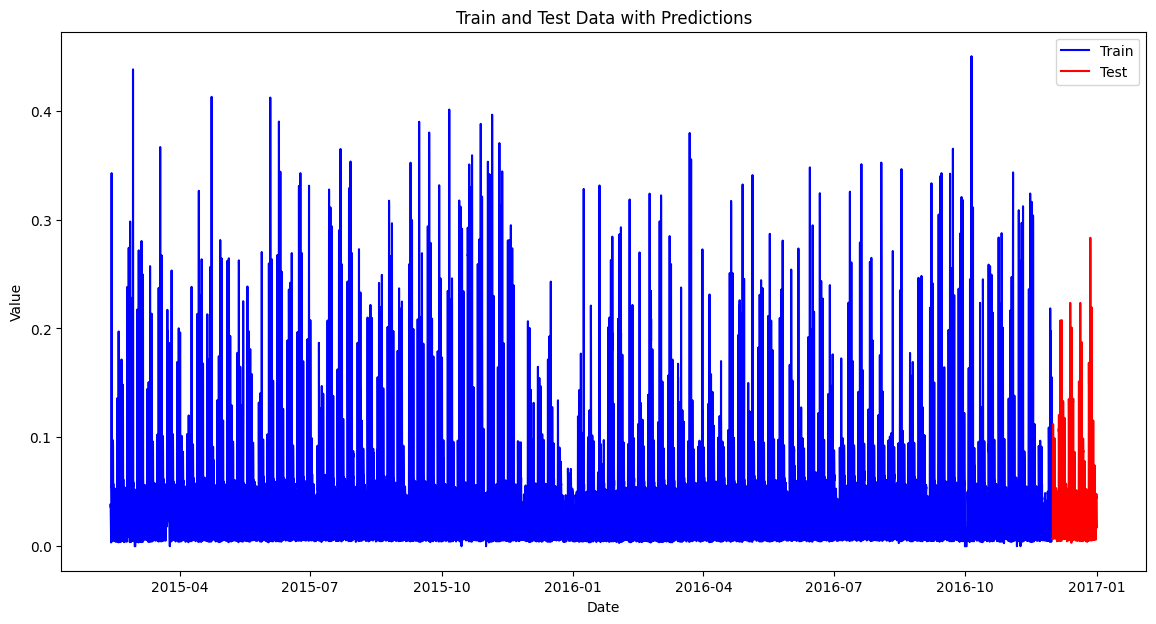

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Value'], label='Train', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Test', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train and Test Data with Predictions')
plt.legend()
plt.show()

# LSTM

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Hyperparameters ---
SEQ_LENGTH = 500  # Number of past values used for prediction
  # Steps to predict (one step at a time)
EPOCHS = 100
BATCH_SIZE = 32
LR = 0.005
HIDDEN_SIZE = 128
NUM_LAYERS = 4

# --- Generate Synthetic Data (Replace with your dataset) ---
np.random.seed(42)
time_series = np.array(train['X'].tolist()[:2000])

# Normalize data
scaler = MinMaxScaler()
time_series = scaler.fit_transform(time_series.reshape(-1, 1)).flatten()


Using device: cuda


In [11]:
# --- Create Training Sequences ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])  # Only predicting next step
    return np.array(X), np.array(y)

X, y = create_sequences(time_series, SEQ_LENGTH)

# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

PREDICT_LENGTH = len(y_test)

In [12]:



# --- Define LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Predicts single value

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Use last timestep output
        return out

# Initialize model
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- Train the Model ---
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train.unsqueeze(-1))
    loss = criterion(outputs.squeeze(), y_train)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.6f}")

# --- Recursive Prediction (Step-by-Step) ---
model.eval()
with torch.no_grad():
    input_seq = X_test[0].tolist()  # Take the first test sequence
    predictions = []

    for _ in range(PREDICT_LENGTH):
        input_tensor = torch.tensor(input_seq[-SEQ_LENGTH:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
        next_pred = model(input_tensor).item()  # Predict one step
        predictions.append(next_pred)
        input_seq.append(next_pred)  # Feed back into input



Epoch [10/100], Loss: 0.015042
Epoch [20/100], Loss: 0.014896
Epoch [30/100], Loss: 0.013364
Epoch [40/100], Loss: 0.010677
Epoch [50/100], Loss: 0.003769
Epoch [60/100], Loss: 0.003149


KeyboardInterrupt: 

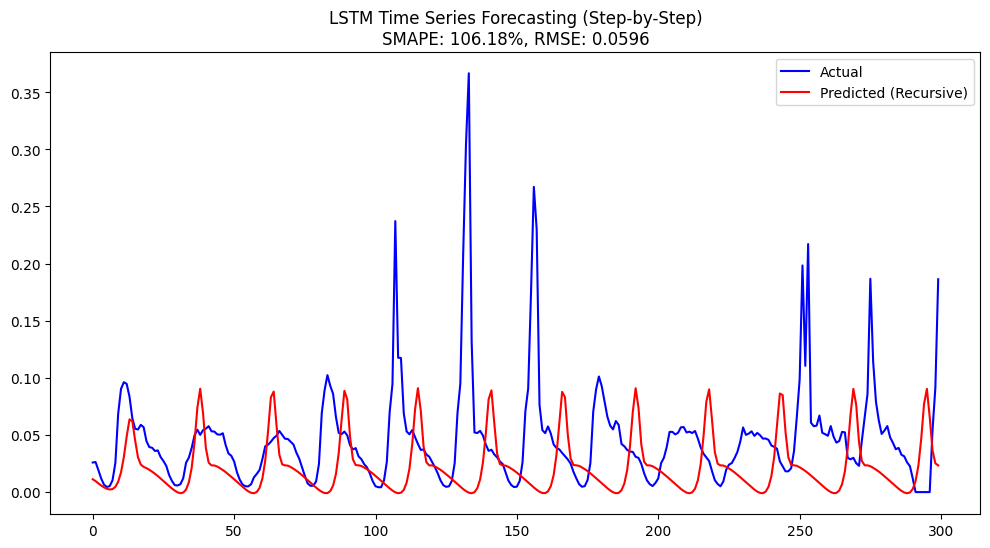

In [9]:
# Convert predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test[:PREDICT_LENGTH].cpu().reshape(-1, 1))

# Calculate SMAPE and RMSE
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

smape_error = smape(y_test_actual, predictions)
rmse_error = rmse(y_test_actual, predictions)

# --- Plot Results ---
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual", color='blue')
plt.plot(predictions, label="Predicted (Recursive)", color='red')
plt.legend()
plt.title(f"LSTM Time Series Forecasting (Step-by-Step)\nSMAPE: {smape_error:.2f}%, RMSE: {rmse_error:.4f}")
plt.show()


In [18]:
try:
    del y_test
except:
    pass

try:
    del model
except:
    pass

try:
    del X_train
except:
    pass

try:
    del y_train
except:
    pass

try:
    del y_test
except:
    pass


In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()


In [21]:
import torch

print(torch.cuda.memory_allocated())  # Total memory allocated
print(torch.cuda.memory_reserved())   # Total memory reserved by caching allocator


25069568
6499074048


In [ ]:
torch.cuda.synchronize()  # Ensures all streams have completed


# Make one-shot prediction

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

def create_sequences(time_series, input_seq_len, output_seq_len):
    inputs = []
    targets = []
    for i in range(len(time_series) - input_seq_len - output_seq_len):
        inputs.append(time_series[i:i + input_seq_len])
        targets.append(time_series[i + input_seq_len:i + input_seq_len + output_seq_len])
    return np.array(inputs), np.array(targets)

In [20]:
SEQ_LENGTH = 1000
OUTPUT_SEQ_LENGTH = 744
EPOCHS = 100
BATCH_SIZE = 32
LR = 0.005
HIDDEN_SIZE = 128
NUM_LAYERS = 4

In [21]:
time_series =  train['X'].tolist()[-5000:]



X, y = create_sequences(time_series, SEQ_LENGTH, OUTPUT_SEQ_LENGTH)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y = np.reshape(y, (y.shape[0], y.shape[1]))

In [22]:
X_train = X[:-1000]
y_train = y[:-1000]
X_test = X[-1000:]
y_test = y[-1000:]

In [25]:


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = LSTMModel(input_size=1, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SEQ_LENGTH, num_layers=NUM_LAYERS)
model = model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)



for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")

model.eval()

X_test = np.array(X_test)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).cuda()

with torch.no_grad():
    predictions = model(X_test_tensor)

predictions = predictions.cpu().numpy()



Epoch [10/100], Loss: 0.000789
Epoch [20/100], Loss: 0.000604
Epoch [30/100], Loss: 0.000560
Epoch [40/100], Loss: 0.000540
Epoch [50/100], Loss: 0.000536
Epoch [60/100], Loss: 0.000506
Epoch [70/100], Loss: 0.000492
Epoch [80/100], Loss: 0.000468
Epoch [90/100], Loss: 0.000454
Epoch [100/100], Loss: 0.000433


In [30]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))


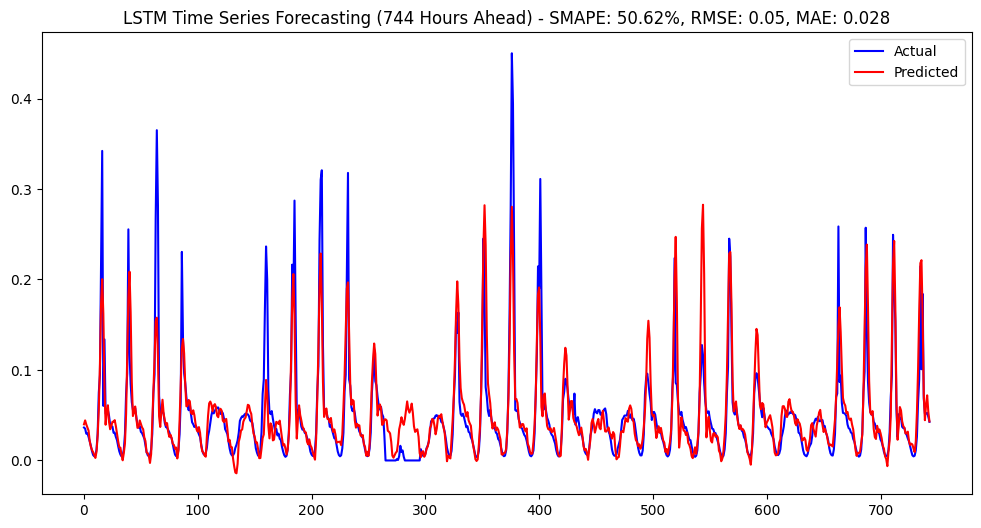

In [31]:

index_chosen = 7

smape_value = smape(y[index_chosen], predictions[index_chosen])
rmse_value = rmse(y[index_chosen], predictions[index_chosen])
mae_value = mae(y[index_chosen], predictions[index_chosen])

plt.figure(figsize=(12, 6))
plt.plot(y_test[index_chosen], label="Actual", color='blue')
plt.plot(predictions[index_chosen], label="Predicted", color='red')
plt.legend()
plt.title(f"LSTM Time Series Forecasting (744 Hours Ahead) - SMAPE: {smape_value:.2f}%, RMSE: {rmse_value:.2f}, MAE: {mae_value:.3f}")
plt.show()


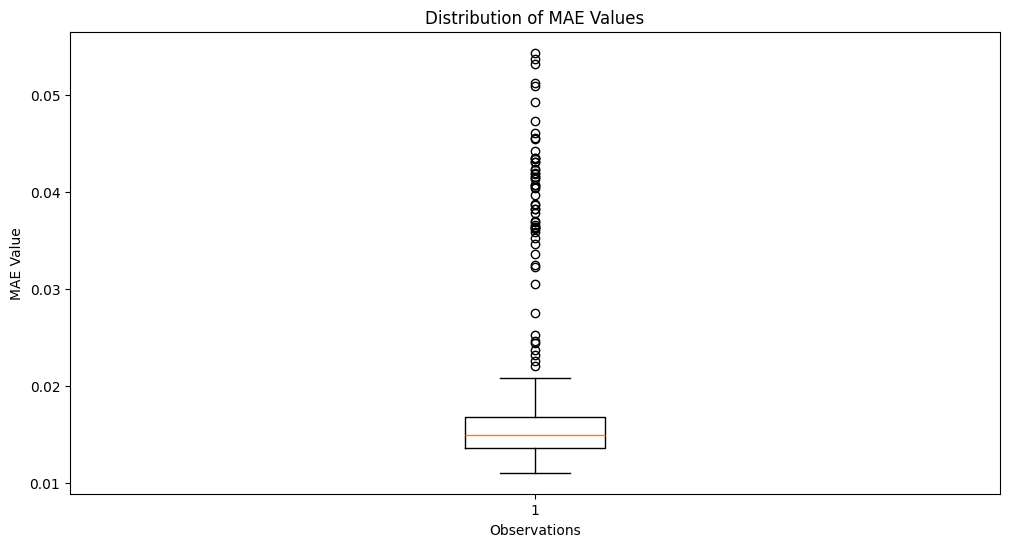

In [32]:
mae_values = [mean_absolute_error(y_test[i], predictions[i]) for i in range(len(y_test))]

plt.figure(figsize=(12, 6))
plt.boxplot(mae_values)
plt.title("Distribution of MAE Values")
plt.xlabel("Observations")
plt.ylabel("MAE Value")
plt.show()
